# Final Project - Basics of deep learning
---
<br>

### Name and ID:
Yoav Gal: -
<br>
Guy Houri: -

# Must Run Installations

In [ ]:
%%capture
# for local developments (no colab) 
%pip install scipy matplotlib pillow numpy pandas tqdm torch torchvision scikit-learn gdown kagglehub openpyxl tk ipython-autotime

In [3]:
%%capture
%pip install ipython-autotime
%load_ext autotime

time: 337 μs (started: 2025-03-05 21:07:28 +02:00)


In [4]:
!gdown 1Yp2acaCWG92n7_nfJjP-8WF8GE0BeVI6 # stanford_cars.xlsx

Downloading...
From: https://drive.google.com/uc?id=1Yp2acaCWG92n7_nfJjP-8WF8GE0BeVI6
To: /Users/yoavgal/code/car-classification/stanford_cars.xlsx
100%|████████████████████████████████████████| 686k/686k [00:00<00:00, 2.79MB/s]
time: 4.69 s (started: 2025-03-05 21:07:28 +02:00)


In [5]:
!gdown 1vHFHmmi1eQgXmFipaWnIbpSjjDAgRftV # train_image_vectors.pt

Downloading...
From (original): https://drive.google.com/uc?id=1vHFHmmi1eQgXmFipaWnIbpSjjDAgRftV
From (redirected): https://drive.google.com/uc?id=1vHFHmmi1eQgXmFipaWnIbpSjjDAgRftV&confirm=t&uuid=077cba54-dd39-4daf-af5f-5a8b0bf4654d
To: /Users/yoavgal/code/car-classification/train_image_tensors.pt
100%|██████████████████████████████████████| 4.90G/4.90G [02:15<00:00, 36.3MB/s]
time: 2min 20s (started: 2025-03-05 21:07:33 +02:00)


In [6]:
!gdown 15RTffuX0FulMrbdGKS606QiJhCqJFfTa # test_image_tensors.pt

Downloading...
From (original): https://drive.google.com/uc?id=15RTffuX0FulMrbdGKS606QiJhCqJFfTa
From (redirected): https://drive.google.com/uc?id=15RTffuX0FulMrbdGKS606QiJhCqJFfTa&confirm=t&uuid=fc1c65a1-d94b-47e6-9057-e500330b9091
To: /Users/yoavgal/code/car-classification/test_image_tensors.pt
100%|██████████████████████████████████████| 4.84G/4.84G [01:50<00:00, 43.9MB/s]
time: 1min 55s (started: 2025-03-05 21:09:53 +02:00)


In [ ]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
path

/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


time: 524 ms (started: 2025-03-05 21:11:49 +02:00)


In [8]:
!mkdir ./content
!mkdir ./content/images/
!mkdir ./content/images/test
!mkdir ./content/images/train


mkdir: ./content: File exists
mkdir: ./content/images/: File exists
mkdir: ./content/images/test: File exists
mkdir: ./content/images/train: File exists
time: 907 ms (started: 2025-03-05 21:11:49 +02:00)


In [9]:

!mv /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_test/cars_test/* ./content/images/test
!mv /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_train/cars_train/* ./content/images/train
!mv /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_annos.mat ./content/

zsh:1: no matches found: /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_test/cars_test/*
zsh:1: no matches found: /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_train/cars_train/*
mv: /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_annos.mat: No such file or directory
time: 719 ms (started: 2025-03-05 21:11:50 +02:00)


# Must Run Utils

### imports

In [ ]:
%%capture
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
import textwrap
from collections import Counter
from tqdm import tqdm
from typing import Optional, List, Tuple, Callable, Union
import pickle
import random

import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

import tkinter as tk
from tkinter import filedialog
from cars_dataset import CarsDataset, get_train_val_dataset,redistribute_test_data


In [ ]:
images_path = "./content/images"

### Image

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

def create_image_tensor(image: Image.Image) -> torch.Tensor:
  image = image.convert('RGB')
  transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS)
    ])
  resized_image = transform(image)
  tensor_image = torch.from_numpy(np.array(resized_image)).permute(2, 0, 1).float()  # (Channel, Height, Width)

  return tensor_image.to(device)

def create_image_grayscale_tensor(image, size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(size, interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
    return transform(image).to(device)

def image_tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
  return tensor.cpu().permute(1, 2, 0).numpy().astype(np.uint8)

def display_tensor(tensor: torch.Tensor, grayscale=False):
  tensor = tensor * 255 if grayscale else tensor
  img = image_tensor_to_numpy(tensor) 
  if grayscale:
    plt.imshow(img, cmap="gray",vmin=0, vmax=255)
  else:
    plt.imshow(image_tensor_to_numpy(tensor))
  plt.axis("off")
  plt.show()

### Normalization


For each model we will do its own preprocessing. <br>
We must use the same normalization (or preprocessing) method during inference (when we use the pre-trained model) as was used during the model's training.  This is crucial for getting accurate and consistent results.

In [ ]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]) 
imagenet_std = torch.tensor([0.229, 0.224, 0.225]) 

normalize_imagenet = transforms.Compose([
    transforms.Lambda(lambda x: x.to("cpu") / 255.0),
    transforms.Normalize(mean=imagenet_mean.squeeze(), std=imagenet_std.squeeze())
])

unnormalize_imagenet = transforms.Compose([
        transforms.Normalize(mean=(-imagenet_mean.squeeze() / imagenet_std.squeeze()),
                             std=(1.0 / imagenet_std.squeeze())),  # Invert normalization parameters
        transforms.Lambda(lambda x: x.to("cpu") * 255.0),
    ])

In [ ]:
# normalize stanford (based on our images)

train_mean = np.array([107.3938, 102.0590, 102.5546])
train_std = np.array([73.6315, 72.5105, 73.7138])

normalize_stanford = transforms.Compose([
    #transforms.Lambda(lambda x: x.to("cpu") / 255.0),  # Divide by 255 in place
    transforms.Normalize(mean=train_mean, std=train_std)
])

unnormalize_stanford = transforms.Compose([
        transforms.Normalize(mean=(-train_mean.squeeze() / train_std.squeeze()),
                             std=(1.0 / train_mean.squeeze())),  # Invert normalization parameters
        #transforms.Lambda(lambda x: x.to("cpu") * 255.0),  # Multiply by 255 in place
    ])

### Read From excel

In [ ]:
class_names = scipy.io.loadmat('./content/cars_annos.mat')['class_names']
class_names_list = [name[0] for name in class_names[0]]
num_classes = len(class_names_list)

In [ ]:
def plot_car(image, class_label: int):
  model_name = class_names_list[class_label]
  title = f"Class {class_label + 1} → \"{model_name}\""

  try:
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()
  except FileNotFoundError:
    print(f"Image file not found")

class Car:
    def __init__(self, image_path: str, x_top_left: int, y_top_left: int, x_bottom_right: int, y_bottom_right: int, class_label: int):
        self.image_path = images_path + image_path
        self.x_top_left = x_top_left
        self.y_top_left = y_top_left
        self.x_bottom_right = x_bottom_right
        self.y_bottom_right = y_bottom_right
        self.class_label = class_label - 1

    def __repr__(self):
      return (f"CarAnnotation(image_path='{self.image_path}', "
            f"bbox=({self.x_top_left}, {self.y_top_left}, {self.x_bottom_right}, {self.y_bottom_right}), "
            f"class_label={self.class_label}")

    def get_image(self) -> Image.Image:
      image = Image.open(self.image_path)
      image = image.crop((self.x_top_left, self.y_top_left, self.x_bottom_right, self.y_bottom_right))

      return image

    def plot(self):
      image = self.get_image()
      plot_car(image, self.class_label)

In [ ]:
excel_file = pd.ExcelFile("stanford_cars.xlsx")
train_df = excel_file.parse("train")
test_df = excel_file.parse("test")

In [ ]:
def create_cars_array(folder: str, df: pd.DataFrame) -> List[Car]:
  arr = []

  for index, row in df.iterrows():
    car = Car(
      os.path.join("/", folder, row['image']),
      int(row['x1']),
      int(row['y1']),
      int(row['x2']),
      int(row['y2']),
      int(row['class']))

    arr.append(car)

  return arr

train_cars = create_cars_array('train', train_df)
test_cars = create_cars_array('test', test_df)

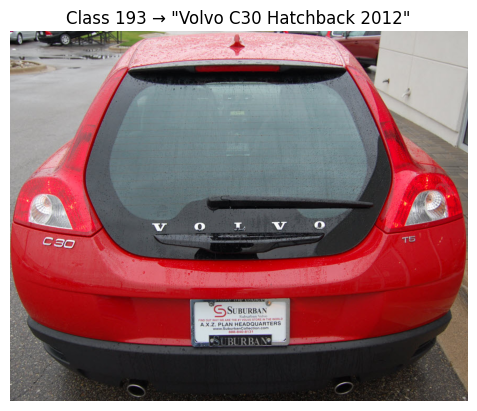

In [ ]:
car = train_cars[100]
car.plot()

### Testing

In [ ]:
def save_best_model(model: nn.Module, model_filename: str) -> None:
  # Create a directory for saving models if it doesn't exist
  save_dir = os.path.join(os.getcwd(), "saved_models")
  os.makedirs(save_dir, exist_ok=True)
  
  # Save the model locally
  save_path = os.path.join(save_dir, model_filename)
  torch.save(model.state_dict(), save_path)
  print(f"Model saved to {save_path}")

def test_model_with_image(model: nn.Module, filename: str, normalize_fn: Callable[[torch.Tensor], torch.Tensor]) -> None:
  # Use absolute path for the image
  image_path = filename
  img = Image.open(image_path)
  img_tensor = create_image_tensor(img)
  img_tensor = normalize_fn(img_tensor)
  img_tensor = img_tensor.unsqueeze(0).to(device) # Add a batch dimension

  with torch.no_grad():
    model.eval()
    outputs = model(img_tensor.to(device))
    _, preds = torch.max(outputs, 1)

  plt.imshow(img)
  plt.title(f"Predicted: {class_names_list[preds[0]]}")
  plt.axis("off")
  plt.show()

def test_model_upload_images(model: nn.Module, normalize_fn: Callable[[torch.Tensor], torch.Tensor]):
  # Use tkinter file dialog instead of Colab's files.upload()
  root = tk.Tk()
  root.withdraw()  # Hide the main window
  
  # Open file dialog to select images
  filepaths = filedialog.askopenfilenames(
      title="Select images to test",
      filetypes=[("Image files", "*.jpg *.jpeg *.png")]
  )
  
  # Process each selected file
  for filepath in filepaths:
    test_model_with_image(model, filepath, normalize_fn)


In [ ]:
%%script echo skipping
from google.colab import files, drive

def save_best_model(model: nn.Module, model_filename: str) -> None:
  drive.mount('./content/drive')
  torch.save(model.state_dict(), f'./content/drive/MyDrive/studying/cs/2024-2025/deep-learning/final-project-deep-learning/exp-weights/{model_filename}')

def test_model_with_image(model: nn.Module, filename: str, normalize_fn: Callable[[torch.Tensor], torch.Tensor]) -> None:
  image_path = "./content/" + filename
  img = Image.open(image_path)
  img_tensor = create_image_tensor(img)
  img_tensor = normalize_fn(img_tensor)
  img_tensor = img_tensor.unsqueeze(0).to(device) # Add a batch dimension

  with torch.no_grad():
    model.eval()
    outputs = model(img_tensor.to(device))
    _, preds = torch.max(outputs, 1)

  plt.imshow(img)
  plt.title(f"Predicted: {class_names_list[preds[0]]}")
  plt.axis("off")
  plt.show()

def test_model_upload_images(model:  nn.Module, normalize_fn: Callable[[torch.Tensor], torch.Tensor]):
  uploaded = files.upload()
  for filename in uploaded.keys():
    test_model_with_image(model, filename, normalize_fn)

skipping


# Pre Process

### Image Tensors

In [33]:
def resize_images(cars: List[Car], grayscale=False, size=(224, 224)) -> torch.Tensor:
    tensor_creator = create_image_tensor if not grayscale else  lambda x: create_image_grayscale_tensor(x, size)
    image_tensors = []

    for car in tqdm(cars, desc="Resizing Images"):
        image_tensor = tensor_creator(car.get_image())
        image_tensors.append(image_tensor)

    return torch.stack(image_tensors)

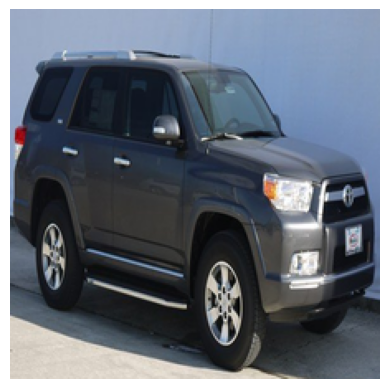

In [34]:
a = test_cars[100].get_image()
tensor_image = create_image_tensor(a)
display_tensor(tensor_image)

#### Resize Tensors

In [35]:
%%script echo skipping

train_image_tensors = resize_images(train_cars)
test_image_tensors = resize_images(test_cars)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

skipping


#### Save Tensors

In [36]:
%%script echo skipping

from google.colab import drive

drive.mount('./content/drive')

torch.save(train_image_tensors, "./content/drive/MyDrive/studying/cs/2024-2025/deep-learning/final-project-deep-learning/tensors/train_image_tensors.pt")
torch.save(test_image_tensors, "./content/drive/MyDrive/studying/cs/2024-2025/deep-learning/final-project-deep-learning/tensors/test_image_tensors.pt")

skipping


#### Load Tensors

In [37]:
#%%script echo skipping

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

def load_image_tensors() -> Tuple[torch.Tensor, torch.Tensor]:
  train_image_tensors = torch.load("./content/train_image_tensors.pt", map_location=device)
  test_image_tensors = torch.load("./content/test_image_tensors.pt", map_location="cpu")

  return train_image_tensors, test_image_tensors

train_image_tensors, test_image_tensors = load_image_tensors()

### Create Dataset

In [38]:
# class CarsDataset(Dataset):
#     def __init__(self, image_tensors: List[torch.Tensor], labels: np.ndarray, normalize_func=None):
#       self.image_tensors = image_tensors
#       self.labels = torch.LongTensor(labels)
#       self.normalize = normalize_func

#     def __len__(self) -> int:
#         return len(self.image_tensors)

#     def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
#       image, label = self.image_tensors[idx], self.labels[idx]

#       if self.normalize:
#         image = self.normalize(image)

#       return image, label, idx


train_labels = np.array([car.class_label for car in train_cars], dtype=np.int32)
test_labels = np.array([car.class_label for car in test_cars], dtype=np.int32)

# def get_train_val_dataset(image_tensors: List[torch.Tensor], image_labels: np.ndarray, normalize_func=None) -> Tuple[Dataset, Dataset]:
#   dataset = CarsDataset(image_tensors, image_labels, normalize_func)
#   train_size = int(0.8 * len(image_tensors))  # 80% for training
#   val_size = len(image_tensors) - train_size  # Remaining 20% for validation
#   train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#   return train_dataset, val_dataset


full_images = list(train_image_tensors) + list(test_image_tensors)
full_labels = np.concatenate((train_labels, test_labels), axis=0)

### Data Loaders

In [39]:
batch_size = 32

train_dataset, val_dataset = get_train_val_dataset(list(train_image_tensors), train_labels, normalize_imagenet)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)

test_dataset = CarsDataset(list(test_image_tensors), test_labels, normalize_imagenet)
test_loader = DataLoader(test_dataset, batch_size)

In [40]:
full_dataset = CarsDataset(full_images, full_labels, normalize_imagenet)

full_dataset_loader = DataLoader(full_dataset, batch_size)

# Training Utils


In [29]:
def validate(model: nn.Module, val_loader: DataLoader, device: torch.device, criterion: nn.Module) -> Tuple[float, float]:
  """
    Returns:
        Tuple[float, float]: A tuple containing the validation accuracy and average loss.
  """
  model.eval()
  correct = 0
  total = 0
  running_loss = 0.0

  with torch.no_grad():
        for images, labels, _ in val_loader:  # Iterate over batches
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  avg_loss = running_loss / len(val_loader)

  return accuracy, avg_loss

In [30]:
def visualize_results(train_losses: List[float], val_losses: List[float], train_accuracies: List[float], val_accuracies: List[float]) -> None:
    """
    Args:
        train_losses (List[float]): List of training loss values for each epoch.
        val_losses (List[float]): List of validation loss values for each epoch.
        train_accuracies (List[float]): List of training accuracy values for each epoch.
        val_accuracies (List[float]): List of validation accuracy values for each epoch.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # Plot for Loss
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)  # Plot for Accuracy
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [31]:
def generate_classification_report(model: nn.Module, data_loader: DataLoader, device: torch.device) -> None:
    y_true: List[int] = []
    y_pred: List[int] = []

    model.eval()
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

In [32]:
def training_loop(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    metric_fn: Optional[Callable[[float, float], float]] = None,
    is_clip: bool = False,
    clip_value: float = 1.0,
    is_l1: bool = False,
    none_blocking: bool = False,
    ) -> Tuple[List[float], List[float], List[float], List[float]]:

    # Lists to store training and validation metrics
    train_losses: List[float] = []
    val_losses: List[float] = []
    train_accuracies: List[float] = []
    val_accuracies: List[float] = []

    # Training and validation loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False) # add tqdm
        for images, labels, _ in train_loop:
            images, labels = images.to(device, non_blocking=none_blocking), labels.to(device, non_blocking=none_blocking)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            if is_l1:
              l1_loss = model.calculate_l1_loss()
              total_loss = loss + l1_loss
              total_loss.backward()
            else:
              loss.backward()

            if is_clip:
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Store training metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        val_accuracy, val_loss = validate(model, val_loader, device, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Step the scheduler with the metric if scheduler and metric_fn are provided
        if scheduler and metric_fn:
            metric = metric_fn(val_accuracy, val_loss)
            scheduler.step(metric)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Transfer Learning

## First Expirement - Naive Approach




<u>Freezing Only Classification</u>

MobileNet-v3-Small, like most pre-trained models available in torchvision.models, is trained on the ImageNet dataset, specifically the ILSVRC 2012 classification dataset.

This dataset contains approximately 1.2 million training images belonging to 1,000 different classes.



**avoid Overfitting:** With a relatively small dataset, training the entire model (including the pre-trained feature extraction layers) is more likely to lead to overfitting. This means the model will perform well on the training data but poorly on unseen data.

**Preserving Learned Features:** The pre-trained feature extraction part of the MobileNetV3 model has learned valuable general image features from the massive ImageNet dataset. Freezing these layers prevents these learned features from being "forgotten" or distorted during training on your smaller dataset.

**Faster Training:** Training only the classifier is significantly faster than training the entire model, as there are fewer parameters to update.



/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /Users/yoavgal/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 31.0MB/s]


Epoch [1/10], Loss: 4.4021, Validation Loss: 3.4695, Validation Accuracy: 22.41%


Epoch [2/10], Loss: 2.5558, Validation Loss: 2.8661, Validation Accuracy: 33.52%


Epoch [3/10], Loss: 1.7762, Validation Loss: 2.5796, Validation Accuracy: 38.86%


Epoch [4/10], Loss: 1.3035, Validation Loss: 2.5221, Validation Accuracy: 41.62%


Epoch [5/10], Loss: 1.0082, Validation Loss: 2.5128, Validation Accuracy: 41.80%


Epoch [6/10], Loss: 0.7929, Validation Loss: 2.4506, Validation Accuracy: 43.65%


Epoch [7/10], Loss: 0.6045, Validation Loss: 2.4100, Validation Accuracy: 44.87%


Epoch [8/10], Loss: 0.4832, Validation Loss: 2.4509, Validation Accuracy: 44.01%


Epoch [9/10], Loss: 0.3738, Validation Loss: 2.4353, Validation Accuracy: 43.89%


Epoch [10/10], Loss: 0.3251, Validation Loss: 2.5159, Validation Accuracy: 44.14%


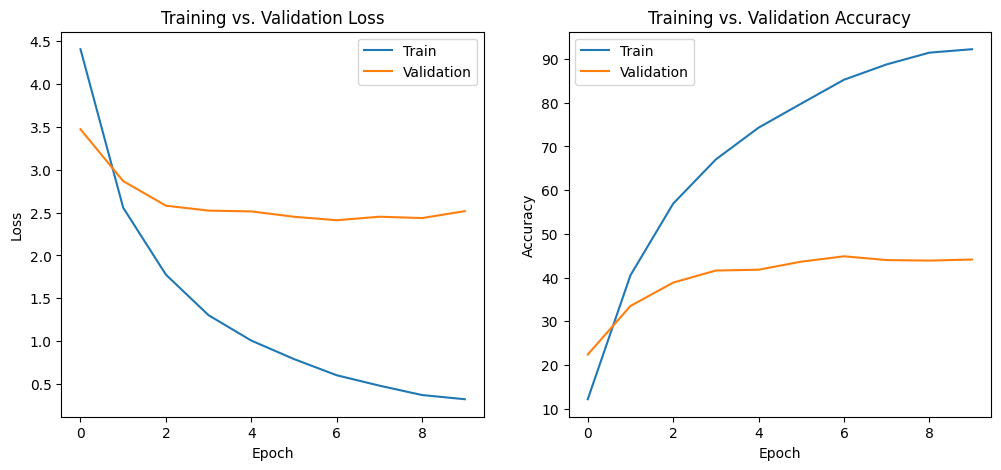

Accuracy: 0.4389
F1 Score: 0.4424
Precision: 0.5167
Recall: 0.4389
time: 1min 43s (started: 2025-03-05 15:21:59 +02:00)


In [81]:
#%%script echo skipping

# create model
exp_1_1_model = models.mobilenet_v3_small(pretrained=True)
exp_1_1_model.classifier[3] = nn.Linear(exp_1_1_model.classifier[3].in_features, num_classes)
exp_1_1_model.classifier

# hyperparameters
epochs = 10
lr = 0.001

# Freeze all layers
for param in exp_1_1_model.parameters():
  param.requires_grad = False

# Unfreeze classifier parameters
for param in exp_1_1_model.classifier.parameters():
  param.requires_grad = True

exp_1_1_model.to(device)
optimizer = optim.Adam(exp_1_1_model.classifier.parameters(), lr)
criterion = nn.CrossEntropyLoss().to(device)

# run and test model
train_losses, val_losses, train_accuracies, val_accuracies = training_loop(exp_1_1_model, optimizer, criterion, epochs, train_loader, val_loader)
visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)
generate_classification_report(exp_1_1_model, test_loader, device)

## Expirement 2 - Avoid Overfitting









<u>Steps To Avoid Overfitting</u> <br>
in the last expirement overfitting was high.

**First Step: L2 Regularization**
L2 (Ridge):  reducing the influence of all features. Adds the square of the weights to the loss function. This encourages smaller weights overall, but doesn't necessarily drive them to zero. It helps to prevent overfitting by reducing the influence of any single feature and penalizing large weights.

**Reduce Learning Rate** If the training loss is decreasing rapidly but the validation loss is not improving or is increasing, it might indicate that the learning rate is too high, causing the model to overfit quickly. so we change from 0.001 to 0.0001.

**Using a pre-trained model with fewer parameters** Using MobileNetV2 instead of MobileNetV3, can be a good strategy for smaller datasets. Models with fewer parameters are less likely to overfit to small datasets because they have less capacity to memorize the training data.

**Dropout** Randomly setting a fraction of the input units to 0 at each update during training time, which helps prevent the network from becoming too reliant on specific neurons. This forces the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.

How Dropout Works
During Training:

At each training step, dropout randomly selects a subset of neurons and sets their activations to zero.
The neurons that are "dropped out" are chosen independently with a probability ( p ) (dropout rate).
The remaining neurons are scaled up by a factor of ( \frac{1}{1-p} ) to maintain the overall scale of the activations.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 5.2873, Validation Loss: 5.0822, Validation Accuracy: 2.95%
Epoch [2/10], Loss: 4.9657, Validation Loss: 4.8519, Validation Accuracy: 9.09%
Epoch [3/10], Loss: 4.7132, Validation Loss: 4.6624, Validation Accuracy: 13.87%
Epoch [4/10], Loss: 4.4870, Validation Loss: 4.4840, Validation Accuracy: 17.07%
Epoch [5/10], Loss: 4.2761, Validation Loss: 4.3383, Validation Accuracy: 19.15%
Epoch [6/10], Loss: 4.0946, Validation Loss: 4.1849, Validation Accuracy: 23.20%
Epoch [7/10], Loss: 3.9344, Validation Loss: 4.0673, Validation Accuracy: 24.13%
Epoch [8/10], Loss: 3.7653, Validation Loss: 3.9371, Validation Accuracy: 27.44%
Epoch [9/10], Loss: 3.6321, Validation Loss: 3.8404, Validation Accuracy: 28.48%
Epoch [10/10], Loss: 3.4918, Validation Loss: 3.7313, Validation Accuracy: 30.69%


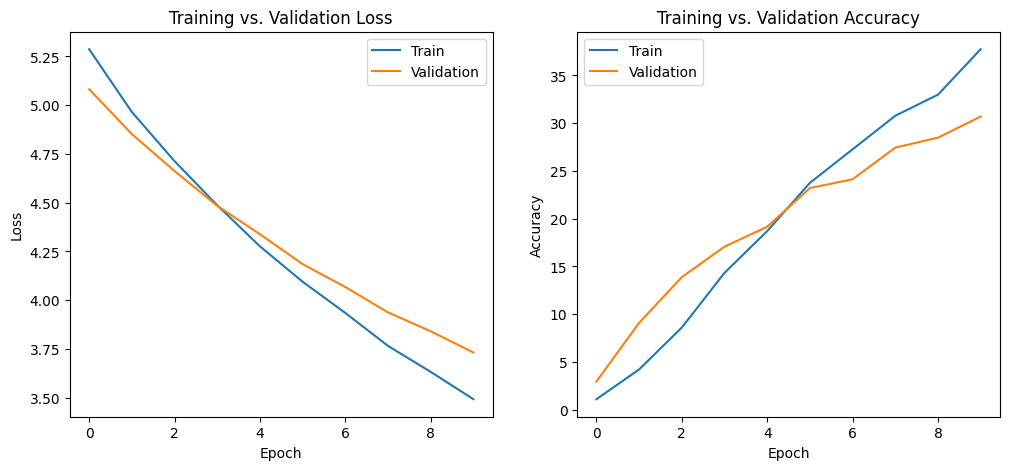

Accuracy: 0.3171
F1 Score: 0.2895
Precision: 0.3796
Recall: 0.3171
time: 2min 46s (started: 2025-02-05 15:32:35 +00:00)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#%%script echo skipping

import torchvision.models as models
import torch.nn as nn

# create model
exp_1_2_model = models.mobilenet_v2(pretrained=True)

# Replace the last layer of the classifier with a new linear layer
num_features = exp_1_2_model.classifier[1].in_features
exp_1_2_model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.35),
    nn.Linear(num_features, num_classes)
)

# hyperparameters
epochs = 10
lr = 0.0001
weight_decay = 0.001

# Freeze all layers
for param in exp_1_2_model.parameters():
  param.requires_grad = False

# Unfreeze classifier parameters
for param in exp_1_2_model.classifier.parameters():
  param.requires_grad = True

exp_1_2_model.to(device)
optimizer = optim.Adam(exp_1_2_model.classifier.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss().to(device)

# run and test
train_losses, val_losses, train_accuracies, val_accuracies = training_loop(exp_1_2_model, optimizer, criterion, epochs, train_loader, val_loader)
visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)
generate_classification_report(exp_1_2_model, test_loader, device)

## Expirement 3 - Different Architecture


<u>Last Chance To Build New Architecture From Scratch</u>

Last Expirement there was no overfitting but model didnt learn well. try from scratch.

**Different Model** ResNet50: Chosen for its depth and ability to learn complex features, with residual connections to mitigate the vanishing gradient problem.

**Add Epochs** from 10 to 20. give the model more time to learn.

**Learning Rate Scheduler** dynamically adjusting the learning rate, try to maximaze validation accuracy (last time was low). patience = 3 -  allow the scheduler to react more quickly to plateaus in the validation loss. factor = 0.5, frequent updates so divide by half.

**Fine tune learning** training only the classifier is not yielding satisfactory results, so we are fine-tuning some of the later layers of the feature extractor. This allows the model to adapt more to the specific characteristics of our dataset, which can sometimes lead to better performance.

In [ ]:
def get_exp_1_3_model() -> nn.Module:
  exp_1_3_model = models.resnet50(pretrained=True)

  # Replace the last layer of the classifier with a new linear layer
  exp_1_3_model.fc = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(exp_1_3_model.fc.in_features, num_classes))

  # Freeze initial layers and unfreeze later layers
  for param in exp_1_3_model.parameters():
    param.requires_grad = False
  for param in exp_1_3_model.layer4.parameters():  # Unfreeze the last block
    param.requires_grad = True
  for param in exp_1_3_model.fc.parameters():  # Ensure the classifier is unfrozen
    param.requires_grad = True

  exp_1_3_model = exp_1_3_model.to(device)

  return exp_1_3_model

time: 750 µs (started: 2025-03-03 12:28:31 +00:00)


In [ ]:
exp_1_3_model = get_exp_1_3_model()
lr=0.0005
weight_decay=0.005
epochs = 20

optimizer = optim.Adam(filter(lambda p: p.requires_grad, exp_1_3_model.parameters()), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


time: 1.26 s (started: 2025-03-03 12:28:33 +00:00)


Epoch [1/20], Loss: 4.2350, Validation Loss: 3.1681, Validation Accuracy: 22.53%


Epoch [2/20], Loss: 2.5045, Validation Loss: 2.2475, Validation Accuracy: 40.15%


Epoch [3/20], Loss: 1.7996, Validation Loss: 2.1997, Validation Accuracy: 39.90%


Epoch [4/20], Loss: 1.4229, Validation Loss: 1.8993, Validation Accuracy: 47.94%


Epoch [5/20], Loss: 1.2050, Validation Loss: 1.8294, Validation Accuracy: 49.17%


Epoch [6/20], Loss: 1.0304, Validation Loss: 1.6662, Validation Accuracy: 54.02%


Epoch [7/20], Loss: 0.8916, Validation Loss: 1.7143, Validation Accuracy: 53.96%


Epoch [8/20], Loss: 0.7529, Validation Loss: 1.5959, Validation Accuracy: 57.03%


Epoch [9/20], Loss: 0.7243, Validation Loss: 1.6410, Validation Accuracy: 54.57%


Epoch [10/20], Loss: 0.6329, Validation Loss: 1.5090, Validation Accuracy: 59.67%


Epoch [11/20], Loss: 0.5706, Validation Loss: 1.5085, Validation Accuracy: 60.65%


Epoch [12/20], Loss: 0.5552, Validation Loss: 1.5379, Validation Accuracy: 60.71%


Epoch [13/20], Loss: 0.5267, Validation Loss: 1.4939, Validation Accuracy: 61.76%


Epoch [14/20], Loss: 0.4692, Validation Loss: 1.7485, Validation Accuracy: 54.88%


Epoch [15/20], Loss: 0.4601, Validation Loss: 1.5434, Validation Accuracy: 60.10%


Epoch [16/20], Loss: 0.4231, Validation Loss: 1.4777, Validation Accuracy: 60.53%


Epoch [17/20], Loss: 0.4333, Validation Loss: 1.5701, Validation Accuracy: 59.55%


Epoch [18/20], Loss: 0.4337, Validation Loss: 1.3956, Validation Accuracy: 66.05%


Epoch [19/20], Loss: 0.3817, Validation Loss: 1.4810, Validation Accuracy: 63.35%


Epoch [20/20], Loss: 0.3975, Validation Loss: 1.4773, Validation Accuracy: 63.29%


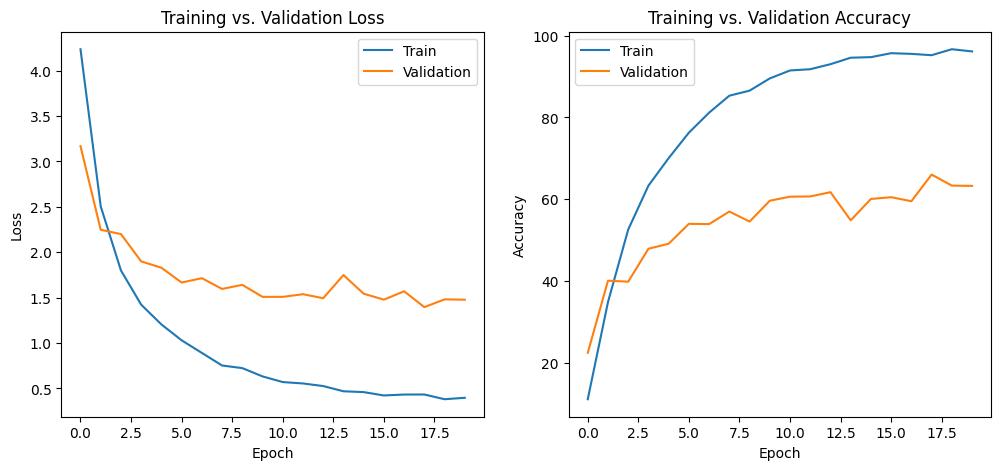

Accuracy: 0.6273
F1 Score: 0.6221
Precision: 0.6962
Recall: 0.6273
time: 13min (started: 2025-03-03 12:28:38 +00:00)


In [ ]:
%%script echo skipping

train_losses, val_losses, train_accuracies, val_accuracies = training_loop(
    exp_1_3_model, optimizer, criterion, epochs, train_loader, val_loader)

visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)
generate_classification_report(exp_1_3_model, test_loader, device)

## Save model

In [ ]:
model_filename = "exp-1-3-best-weights"
#save_best_model(exp_1_3_model)

time: 331 µs (started: 2025-02-20 08:04:42 +00:00)


## Test Best Model

In [ ]:
def create_exp_1_3_model() -> nn.Module:
  exp_1_3_model = models.resnet50(pretrained=True)

  # Replace the last layer of the classifier with a new linear layer
  exp_1_3_model.fc = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(exp_1_3_model.fc.in_features, num_classes))

  # Freeze initial layers and unfreeze later layers
  for param in exp_1_3_model.parameters():
    param.requires_grad = False
  for param in exp_1_3_model.layer4.parameters():  # Unfreeze the last block
    param.requires_grad = True
  for param in exp_1_3_model.fc.parameters():  # Ensure the classifier is unfrozen
    param.requires_grad = True

  exp_1_3_model = exp_1_3_model.to(device)

  return exp_1_3_model

def get_exp_1_3_model() -> nn.Module:
  exp_1_3_model = create_exp_1_3_model()
  !gdown 1Hj_tILlZxcwycx7lTpi11RNClRpH4Iss # exp-1-3-best-weights.
  model_filename = "exp-1-3-best-weights"
  exp_1_3_model.load_state_dict(torch.load(f'./content/{model_filename}', map_location=device))

  return exp_1_3_model

exp_1_3_model = get_exp_1_3_model()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1Hj_tILlZxcwycx7lTpi11RNClRpH4Iss
From (redirected): https://drive.google.com/uc?id=1Hj_tILlZxcwycx7lTpi11RNClRpH4Iss&confirm=t&uuid=521a0711-3b20-4109-95f8-67a6699f80e5
To: /content/exp-1-3-best-weights
100% 96.0M/96.0M [00:01<00:00, 48.6MB/s]
time: 8.26 s (started: 2025-03-03 13:26:58 +00:00)


<ipython-input-17-ffeecc226c65>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp_1_3_model.load_state_dict(torch.load(f'/content/{model_filename}', map_location=device)

Saving 00001.jpg to 00001.jpg
Saving 00002.jpg to 00002.jpg
Saving 00003.jpg to 00003.jpg


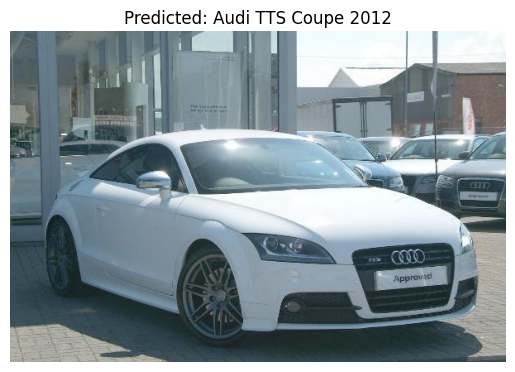

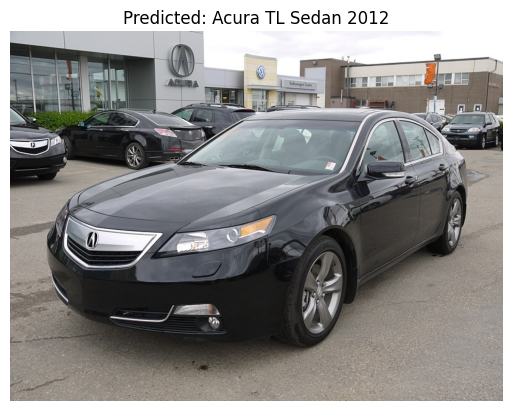

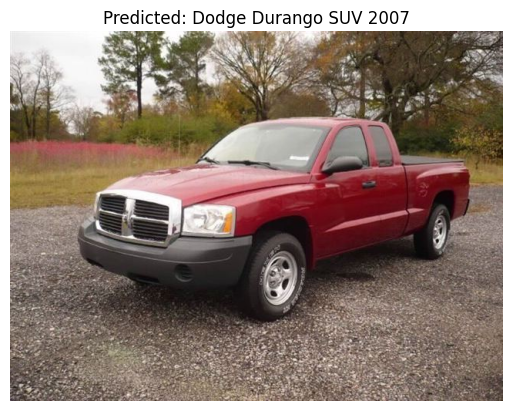

time: 12.9 s (started: 2025-03-03 13:27:08 +00:00)


In [ ]:
#%%script echo skipping

test_model_upload_images(exp_1_3_model, normalize_imagenet)

# Image Retrival


## Utils - MUST RUN FOR TESTS

#### Load Exp-1-3 Model

In [ ]:
def create_exp_1_3_model() -> nn.Module:
  exp_1_3_model = models.resnet50(pretrained=True)

  # Replace the last layer of the classifier with a new linear layer
  exp_1_3_model.fc = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(exp_1_3_model.fc.in_features, num_classes))

  # Freeze initial layers and unfreeze later layers
  for param in exp_1_3_model.parameters():
    param.requires_grad = False
  for param in exp_1_3_model.layer4.parameters():  # Unfreeze the last block
    param.requires_grad = True
  for param in exp_1_3_model.fc.parameters():  # Ensure the classifier is unfrozen
    param.requires_grad = True

  exp_1_3_model = exp_1_3_model.to(device)

  return exp_1_3_model

def get_exp_1_3_model() -> nn.Module:
  exp_1_3_model = create_exp_1_3_model()
  !gdown 1Hj_tILlZxcwycx7lTpi11RNClRpH4Iss # exp-1-3-best-weights.
  model_filename = "exp-1-3-best-weights"
  exp_1_3_model.load_state_dict(torch.load(f'./content/{model_filename}', map_location=device))

  return exp_1_3_model

time: 691 µs (started: 2025-03-05 08:23:09 +00:00)


#### K-Means

In [ ]:
def get_embedding_nearest_neighbors(query_embedding: torch.Tensor, embeddings: np.ndarray, k: int = 4) -> np.ndarray:
    knn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree') # Find  neighbors
    knn.fit(embeddings)
    distances, indices = knn.kneighbors([query_embedding.to('cpu')])

    return indices.flatten()

time: 423 µs (started: 2025-03-05 08:23:09 +00:00)


#### Plotting

In [ ]:
def nearest_neighbor_indices(embedding: torch.Tensor, embeddings: np.ndarray, k: int = 10) -> np.ndarray:
  embedding_np = embedding.cpu().numpy()
  distances = np.linalg.norm(embeddings - embedding_np, axis=1)
  nearest_neighbors_indices = np.argsort(distances)[:k]

  return nearest_neighbors_indices

def print_nearest_neighbors_label(embedding: torch.Tensor, all_embeddings: torch.Tensor, true_labels: np.ndarray, k: int = 10) -> None:
  neighbors_indices = nearest_neighbor_indices(embedding, all_embeddings, k)

  for i, index in enumerate(neighbors_indices):
    print(f"Neighbor {i+1}: Index {index}, True Label: {true_labels[index]}")



def plot_neighbors(embedding: torch.Tensor, embedding_img: Image.Image, embeddings: np.ndarray, dataset: Dataset, k: int = 8):
    neighbors_indices = get_embedding_nearest_neighbors(embedding, embeddings, k)
    images = [embedding_img] + [dataset.image_tensors[idx] for idx in neighbors_indices]
    labels = [dataset.labels[idx] for idx in neighbors_indices]

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    titles = [f'Query'] + [f'Neighbor {i+1} - {class_names_list[label]}' for i, label in enumerate(labels)]

    for ax, img, title in zip(axes, images, titles):
        img = normalize_if_tensor(img)
        ax.imshow(img)
        wrapped_title = "\n".join(textwrap.wrap(title, width=15))  # Wrap the title to fit within the plot
        ax.set_title(wrapped_title, fontsize=10)
        ax.axis('off')

    plt.show()


def normalize_if_tensor(data: Union[torch.Tensor, Image.Image]) -> Image.Image:
  if isinstance(data, torch.Tensor):
    data.to(device)
    return image_tensor_to_numpy(data)
  else:
    return data

time: 1.77 ms (started: 2025-03-05 08:48:38 +00:00)


In [ ]:
def plot_label(clusters: np.ndarray, cluster: int, dataset: Dataset):  # Added parameter
    indices = np.where(clusters == cluster)[0]
    num_images = len(indices)

    # Calculate the number of rows and columns for the grid
    images_per_row = 5
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Ceiling division
    num_cols = min(num_images, images_per_row)  # Up to images_per_row per row

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjusted figure height

    # Flatten the axes array for easy iteration (if it's a 2D array)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes]) # if there is only one plot, convert it to an array to allow iteration

    class_counts = Counter()
    for i, idx in enumerate(indices):
        image_tensor, class_label = dataset[idx]
        image_tensor = unnormalize_imagenet(image_tensor)
        img = image_tensor_to_numpy(image_tensor)
        axes[i].imshow(img)
        axes[i].axis('off')
        class_counts[class_label.item()] += 1

    # Hide any unused subplots (if num_images is not a multiple of images_per_row)
    for j in range(i + 1, len(axes)):
        axes[j].set_axis_off()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    print(f"Summary of class labels in cluster {cluster}:")
    print(f"num vehicles {num_images}")
    for class_label, count in class_counts.most_common(5):
        print(f"Class {class_names_list[class_label]}: {count} images. {count/num_images:.2f}%")

time: 807 µs (started: 2025-03-05 08:23:09 +00:00)


#### Embedding

In [ ]:
def extract_embeddings(dataloader: DataLoader, model: nn.Module) -> np.ndarray:
    all_embeddings = []

    model.eval()
    with torch.no_grad():
        for images, _, _ in tqdm(dataloader, desc="Extracting Embeddings"):  # Only need images
            images = images.to(device)  # Assuming 'device' is defined
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the outputs
            embeddings = outputs.cpu().numpy()
            all_embeddings.append(embeddings)

    return np.concatenate(all_embeddings, axis=0)

def generate_embedding(model: torch.nn.Module, image_tensor: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        embedding = model(image_tensor)

    return embedding.squeeze()

time: 903 µs (started: 2025-03-05 08:23:09 +00:00)


#### Evaluation

##### External Evaluation Metrics


In [ ]:
def print_clusters_purity(cluster_labels: np.ndarray, n_clusters: int, dataset: Dataset) -> None:
  purity = get_clusters_purity(cluster_labels, n_clusters, dataset)
  print(f"Cluster Purity: {purity:.2f}")

def get_clusters_purity(cluster_labels: np.ndarray, n_clusters: int, dataset: Dataset) -> float:
  total_purity = 0

  for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_true_labels = dataset.labels[cluster_indices]
    count_most_common = Counter(cluster_true_labels).most_common(1)[0][1]
    cluster_purity = count_most_common / len(cluster_indices)
    total_purity += cluster_purity

  overall_purity = total_purity / n_clusters

  return overall_purity

time: 886 µs (started: 2025-03-05 08:23:09 +00:00)


##### Internal Evaluation Metrics (K-Means)

In [ ]:
def print_internal_clustering_metrics(embeddings: np.ndarray, cluster_labels: np.ndarray) -> None:
    db_index = davies_bouldin_score(embeddings, cluster_labels)
    print(f"Davies-Bouldin Score: {db_index:.2f}")

    ch_index = calinski_harabasz_score(embeddings, cluster_labels)
    print(f"Calinski-Harabasz Score: {ch_index:.2f}")

    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.2f}")

time: 540 µs (started: 2025-03-05 08:23:09 +00:00)


In [ ]:
from scipy.spatial.distance import pdist

def average_intra_cluster_distance(cluster_points):
    if len(cluster_points) < 2:
        return 0  # No distance to calculate if there is only one point
    distances = pdist(cluster_points, metric='euclidean')
    return np.mean(distances)


def average_intra_cluster_distances(embeddings: np.ndarray, cluster_labels: np.ndarray, n_clusters: int) -> List[float]:
    average_distances = []
    for cluster in range(n_clusters):
        cluster_points = embeddings[cluster_labels == cluster]
        avg_distance = average_intra_cluster_distance(cluster_points)
        average_distances.append(avg_distance)
    return average_distances


def most_similar_clusters(embeddings: np.ndarray, cluster_labels: np.ndarray, n_clusters: int, top_n: int = 3) -> List[int]:
    average_distances = average_intra_cluster_distances(embeddings, cluster_labels, n_clusters)
    most_similar_clusters = np.argsort(average_distances)[:top_n]

    return most_similar_clusters.tolist()


time: 612 µs (started: 2025-03-05 08:23:09 +00:00)


##### Entire Evaluation

In [ ]:
def print_evaluation(embeddings: np.ndarray, cluster_labels: np.ndarray, n_clusters: int, dataset: Dataset) -> None:
  print_clusters_purity(cluster_labels, n_clusters, dataset)
  print_internal_clustering_metrics(embeddings, cluster_labels)

time: 280 µs (started: 2025-03-05 08:23:09 +00:00)


#### Testing

In [ ]:
def test_cluster_upload_images(best_embeddings: np.ndarray, model: nn.Module):
  uploaded = files.upload()
  for filename in uploaded.keys():
    image_path = "/content/" + filename
    embedding_img = Image.open(image_path)
    img_tensor = create_image_tensor(embedding_img)
    img_tensor = normalize_imagenet(img_tensor)
    embedding_img_tensor = img_tensor.unsqueeze(0).to(device) # add batch size dimension
    embedding = generate_embedding(model, embedding_img_tensor)
    plot_neighbors(embedding, embedding_img, best_embeddings, full_dataset, 8)

time: 636 µs (started: 2025-03-05 08:23:09 +00:00)


In [ ]:
def assign_cluster(embedding: torch.Tensor, kmeans: KMeans) -> int:
    embedding_np = embedding.cpu().numpy().reshape(1, -1)
    cluster = kmeans.predict(embedding_np)

    return cluster[0]

time: 284 µs (started: 2025-03-05 08:23:09 +00:00)


## Experiment 1 - Naive Approach

Use Resnet than k-means

In [ ]:
exp_2_1_model = models.resnet50(pretrained=True)
exp_2_1_model.fc = nn.Identity() # in final fully connected passes the input tensor through without any modification.
exp_2_1_model.eval()
exp_2_1_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 2.93 s (started: 2025-02-20 05:56:59 +00:00)


In [ ]:
#%%script echo skipping

embeddings = extract_embeddings(full_dataset_loader, exp_2_1_model)

Extracting Embeddings:  88%|████████▊ | 445/506 [1:01:00<08:20,  8.20s/it]

In [ ]:
exp_2_1_kmeans = KMeans(n_clusters=196, random_state=42)
exp_2_1_kmeans.fit(embeddings)
cluster_labels: np.ndarray = exp_2_1_kmeans.predict(embeddings)

time: 58.2 s (started: 2025-02-20 07:43:50 +00:00)


In [ ]:
print_evaluation(embeddings, cluster_labels, 196, full_dataset)

Cluster Purity: 0.02
Davies-Bouldin Score: 3.20
Calinski-Harabasz Score: 72.94
Silhouette Score: 0.02
time: 42.3 s (started: 2025-02-20 07:46:32 +00:00)


## Expirement 2 - Use Fine Tuned Model

Use our best CNN which was Exp 1-3 model - resnet 50 which was specifically trained on our data

In [ ]:
def get_exp_2_2_model() -> nn.Module:
  exp_2_2_model = get_exp_1_3_model()
  exp_2_2_model.fc = nn.Identity() # in final fully connected passes the input tensor through without any modification.
  exp_2_2_model.eval()
  exp_2_2_model.to(device)

  return exp_2_2_model

  exp_2_2_model = get_exp_2_2_model()

In [ ]:
embeddings = extract_embeddings(full_dataset_loader, exp_2_2_model)

Extracting Embeddings: 100%|██████████| 506/506 [3:21:40<00:00, 23.91s/it]

time: 3h 21min 40s (started: 2025-02-20 12:38:07 +00:00)


In [ ]:
exp_2_2_kmeans = KMeans(n_clusters=196, random_state=42)
exp_2_2_kmeans.fit(embeddings)
cluster_labels: np.ndarray = exp_2_2_kmeans.predict(embeddings)

time: 38.8 s (started: 2025-02-20 16:23:20 +00:00)


In [ ]:
print_evaluation(embeddings, cluster_labels, 196, full_dataset)

Cluster Purity: 0.01
Davies-Bouldin Score: 1.19
Calinski-Harabasz Score: 387.08
Silhouette Score: 0.36
time: 40.3 s (started: 2025-02-20 16:24:46 +00:00)


## Experiment 3 - Dimensionality Reduction

<u> Fix K Means </u>

**Fix Scaling** \\
ResNet-50 Embeddings (and Most CNN Embeddings) Are Not Inherently Scaled. If some features have much larger values than others, they will dominate the distance calculations. This can lead to clusters that are heavily influenced by those features, even if they are not the most important.
Scaling ensures that all features have equal influence on the distance calculations, leading to more balanced and meaningful clusters.

**Dimensionality Reduction** \\
ResNet-50 produces embeddings with a large number of features. In high-dimensional spaces, data becomes sparse, making distance-based calculations less reliable.
Dimensionality reduction can help remove noise and redundant features, leading to more meaningful clusters.

**Ensure K-Means++, and n_init=auto** \\
Default in scklean 1.2+. k-means++ generally outperforms standard k-means in terms of clustering quality. n_init = 'auto' - run kmeans several times. K-means is sensitive to the initial placement of centroids. With random initialization, different runs of k-means can produce significantly different clustering results.
n_init helps mitigate this issue by running the algorithm multiple times with different random centroid initializations.

**Normalize after PCA** \\
Even after PCA, there can still be variations in the magnitudes of the embeddings.Normalization eliminates these variations, ensuring that the distance calculations are based solely on the direction of the vectors.


In [ ]:
# embeddings are the same as experiment 2
best_embeddings_file_path = "/content/best-embeddings.npy"
!gdown 1iWHl6cBZGG9f-RtSRsBEfO-y3N1doiMg# best-embeddings
embeddings = np.load(best_embeddings_file_path)

[0.07800278 0.14997402 0.21724236 ... 0.99999917 0.9999993  0.9999994 ]


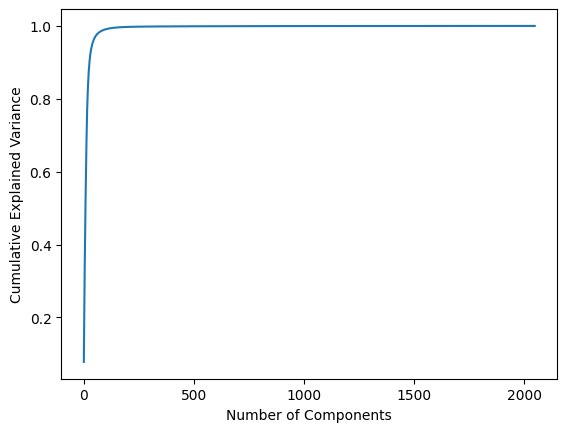

2048
time: 14.4 s (started: 2025-02-20 16:29:58 +00:00)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

# Scale the data
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Apply PCA without specifying n_components
pca = PCA()
pca.fit(scaled_embeddings)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
pca = PCA(n_components=200)
reduced_embeddings = pca.fit_transform(scaled_embeddings)
normalized_embeddings = normalize(reduced_embeddings, axis=1)
kmeans = KMeans(n_clusters=196, random_state=42, init='k-means++', n_init='auto')
cluster_labels = kmeans.fit_predict(normalized_embeddings)

time: 10.5 s (started: 2025-02-20 16:34:47 +00:00)


In [ ]:
print_evaluation(normalized_embeddings, cluster_labels, 196, full_dataset)

Cluster Purity: 0.01
Davies-Bouldin Score: 1.18
Calinski-Harabasz Score: 379.96
Silhouette Score: 0.37
time: 7.24 s (started: 2025-02-20 16:35:00 +00:00)


## Save Best Model

In [ ]:
best_embeddings_file_path = "/content/best-embeddings.npy"
#np.save(best_embeddings_file_path, embeddings)

time: 3.3 s (started: 2025-02-20 16:24:15 +00:00)


## Test Image Retrival
**If We want to run embedding test (find nearest neighbours - we have to run pre process and load the entire image tensors**

In [ ]:
def get_exp_2_2_model() -> nn.Module:
  exp_2_2_model = get_exp_1_3_model()
  exp_2_2_model.fc = nn.Identity() # in final fully connected passes the input tensor through without any modification.
  exp_2_2_model.eval()
  exp_2_2_model.to(device)

  return exp_2_2_model

exp_2_2_model = get_exp_2_2_model()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1Hj_tILlZxcwycx7lTpi11RNClRpH4Iss
From (redirected): https://drive.google.com/uc?id=1Hj_tILlZxcwycx7lTpi11RNClRpH4Iss&confirm=t&uuid=3aa9d906-0e25-4db0-a5bc-4f2e5011fd02
To: /content/exp-1-3-best-weights
100% 96.0M/96.0M [00:01<00:00, 69.0MB/s]
time: 7.63 s (started: 2025-03-05 08:27:39 +00:00)


<ipython-input-28-eebd87d19663>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp_1_3_model.load_state_dict(torch.load(f'/content/{model_filename}', map_location=device)

In [ ]:
!gdown 1iWHl6cBZGG9f-RtSRsBEfO-y3N1doiMg # best-embeddingsb
best_embeddings_file_path = "/content/best-embeddings.npy"
best_embeddings = np.load(best_embeddings_file_path)

Downloading...
From (original): https://drive.google.com/uc?id=1iWHl6cBZGG9f-RtSRsBEfO-y3N1doiMg
From (redirected): https://drive.google.com/uc?id=1iWHl6cBZGG9f-RtSRsBEfO-y3N1doiMg&confirm=t&uuid=7b7ddde7-fecc-4ed0-8438-7ce070756c3a
To: /content/best-embeddings.npy
100% 133M/133M [00:03<00:00, 36.9MB/s]
time: 8.96 s (started: 2025-03-05 08:26:03 +00:00)


Saving 00003.jpg to 00003 (1).jpg


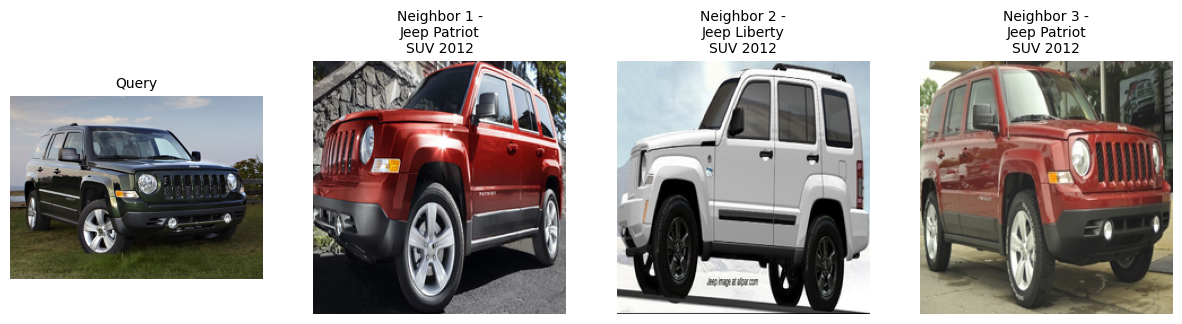

time: 13.7 s (started: 2025-03-05 08:48:55 +00:00)


In [ ]:
test_cluster_upload_images(best_embeddings, exp_2_2_model)

# CNN

### Utils

In [93]:
batch_size = 16

train_dataset, val_dataset = get_train_val_dataset(train_image_tensors, train_labels, normalize_stanford)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)

test_dataset = CarsDataset(test_image_tensors, test_labels, normalize_stanford)
test_loader = DataLoader(test_dataset, batch_size)

In [94]:
train_image_tensors.shape

torch.Size([8144, 3, 224, 224])

## Exp 1 - Naive Approach

<u> Convolutional Layers </u> \\
Convolutional layers (with increasing filter numbers: 16, 32, 64, 128) allows the network to learn increasingly complex and abstract features from the input images. Early layers capture basic edge and texture information, while deeper layers extract more high-level features like shapes and patterns characteristic of different car models.

**"same" padding** ensures that the spatial dimensions of the feature maps remain the same after each convolution, preventing the image from shrinking significantly as it passes through the network.

**3x3 kernels** provides a good balance between capturing local features, computational efficiency, and the ability to learn complex representations through the stacking of multiple layers.

**Max pooling** down samples the feature maps, reducing their spatial dimensions while preserving the most important information. This helps to reduce the computational cost and make the model more robust to small translations or distortions in the input image.
Feature Invariance: Max pooling introduces a form of translation invariance, making the model less sensitive to slight shifts in the position of car features within the image.

**Batch Normalization**normalizes the activations of each layer, improving training stability and accelerating convergence. It also helps to reduce internal covariance shift, making the network less sensitive to changes in the distribution of activations during training.


<u> Fully Connected Layers </u> \\
**fc1 (5096 neurons)** receives the flattened output from the convolutional layers and learns a high-level representation of the image.

**fc2 (1024 neurons):** This layer further processes the information from the previous layer, potentially extracting more abstract features and reducing the dimensionality of the representation.

**fc3 (196 neurons):** This is the output layer. It has 196
 neurons, one for each car class. The softmax activation function is applied to the output of this layer to obtain a probability distribution over the classes.

**Batch Normalization:** Batch normalization layers are included after each dense layer to improve training stability and accelerate convergence.

In [ ]:
class Exp_3_1_model(nn.Module):
    def __init__(self, num_classes=196):
        super(Exp_3_1_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 14 * 14, 5096) # img size (224) / 2 / 2 / 2 / 2 (4 maxpooling) = 14
        self.bn5 = nn.BatchNorm1d(5096)
        self.fc2 = nn.Linear(5096, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.bn5(self.fc1(x)))
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# Create an instance of the model
exp_3_1_model = Exp_3_1_model()
exp_3_1_model.to(device)

Exp_3_1_model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=5096, bias=True)
  (bn5): BatchNorm1d(5096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=5096, out_features=1024, bias=True)
  (bn6): BatchNorm1d(10

In [ ]:
epochs=20
lr=0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(exp_3_1_model.parameters(), lr)

In [ ]:
%%script echo skipping

train_loss, val_loss, train_acc, val_acc = training_loop(
    exp_3_1_model, optimizer, criterion, epochs, train_loader, val_loader)

visualize_results(train_loss, val_loss, train_acc, val_acc)
generate_classification_report(exp_3_1_model, test_loader, device)

## Exp 2 - Reduce Overfitting

In [ ]:
class Exp_3_2_model(nn.Module):
    def __init__(self, num_classes=196):
        super(Exp_3_2_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 14 * 14, 5096) # img size (224) / 2 / 2 / 2 / 2 (4 maxpooling) = 14
        self.bn5 = nn.BatchNorm1d(5096)
        self.dropout1 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(5096, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.8)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# Create an instance of the model
exp_3_2_model = Exp_3_2_model()
exp_3_2_model.to(device)

Exp_3_2_model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=5096, bias=True)
  (bn5): BatchNorm1d(5096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.8, inplace=False)
  (fc2): Linear(in_features=5096, out_featu

time: 1.98 s (started: 2025-03-03 12:43:46 +00:00)


In [ ]:
epochs = 35
lr = 0.00005
weight_decay = 0.005

optimizer = optim.Adam(exp_3_2_model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

time: 1.1 ms (started: 2025-03-03 12:43:52 +00:00)


Epoch [1/35], Loss: 5.6392, Validation Loss: 5.1840, Validation Accuracy: 2.89%


Epoch [2/35], Loss: 5.3939, Validation Loss: 5.1137, Validation Accuracy: 3.62%


Epoch [3/35], Loss: 5.2435, Validation Loss: 5.0534, Validation Accuracy: 5.40%


Epoch [4/35], Loss: 5.0929, Validation Loss: 4.9967, Validation Accuracy: 6.51%


Epoch [5/35], Loss: 4.9452, Validation Loss: 4.9416, Validation Accuracy: 7.12%


Epoch [6/35], Loss: 4.7895, Validation Loss: 4.9007, Validation Accuracy: 7.92%


Epoch [7/35], Loss: 4.6283, Validation Loss: 4.8453, Validation Accuracy: 8.84%


Epoch [8/35], Loss: 4.4744, Validation Loss: 4.8018, Validation Accuracy: 8.29%


Epoch [9/35], Loss: 4.2912, Validation Loss: 4.7659, Validation Accuracy: 10.80%


Epoch [10/35], Loss: 4.1037, Validation Loss: 4.7250, Validation Accuracy: 10.44%


Epoch [11/35], Loss: 3.9348, Validation Loss: 4.6805, Validation Accuracy: 11.60%


Epoch [12/35], Loss: 3.7685, Validation Loss: 4.6483, Validation Accuracy: 11.91%


Epoch [13/35], Loss: 3.5726, Validation Loss: 4.6123, Validation Accuracy: 12.89%


Epoch [14/35], Loss: 3.3925, Validation Loss: 4.6020, Validation Accuracy: 12.65%


Epoch [15/35], Loss: 3.2063, Validation Loss: 4.5439, Validation Accuracy: 14.18%


Epoch [16/35], Loss: 3.0159, Validation Loss: 4.5362, Validation Accuracy: 14.30%


Epoch [17/35], Loss: 2.8177, Validation Loss: 4.4992, Validation Accuracy: 15.78%


Epoch [18/35], Loss: 2.6417, Validation Loss: 4.4723, Validation Accuracy: 14.92%


Epoch [19/35], Loss: 2.4418, Validation Loss: 4.4540, Validation Accuracy: 16.21%


Epoch [20/35], Loss: 2.2957, Validation Loss: 4.4144, Validation Accuracy: 16.08%


Epoch [21/35], Loss: 2.0907, Validation Loss: 4.4032, Validation Accuracy: 17.80%


Epoch [22/35], Loss: 1.9362, Validation Loss: 4.3678, Validation Accuracy: 16.45%


Epoch [23/35], Loss: 1.7536, Validation Loss: 4.3704, Validation Accuracy: 17.56%


Epoch [24/35], Loss: 1.6144, Validation Loss: 4.3457, Validation Accuracy: 17.19%


Epoch [25/35], Loss: 1.4431, Validation Loss: 4.3206, Validation Accuracy: 17.86%


Epoch [26/35], Loss: 1.3058, Validation Loss: 4.3165, Validation Accuracy: 17.86%


Epoch [27/35], Loss: 1.1864, Validation Loss: 4.2790, Validation Accuracy: 19.03%


Epoch [28/35], Loss: 1.0665, Validation Loss: 4.2803, Validation Accuracy: 18.29%


Epoch [29/35], Loss: 0.9639, Validation Loss: 4.2667, Validation Accuracy: 18.97%


Epoch [30/35], Loss: 0.8668, Validation Loss: 4.2332, Validation Accuracy: 17.99%


Epoch [31/35], Loss: 0.7935, Validation Loss: 4.2445, Validation Accuracy: 17.68%


Epoch [32/35], Loss: 0.7322, Validation Loss: 4.2406, Validation Accuracy: 17.62%


Epoch [33/35], Loss: 0.6693, Validation Loss: 4.2000, Validation Accuracy: 17.74%


Epoch [34/35], Loss: 0.6127, Validation Loss: 4.1991, Validation Accuracy: 19.15%


Epoch [35/35], Loss: 0.5532, Validation Loss: 4.2049, Validation Accuracy: 18.29%


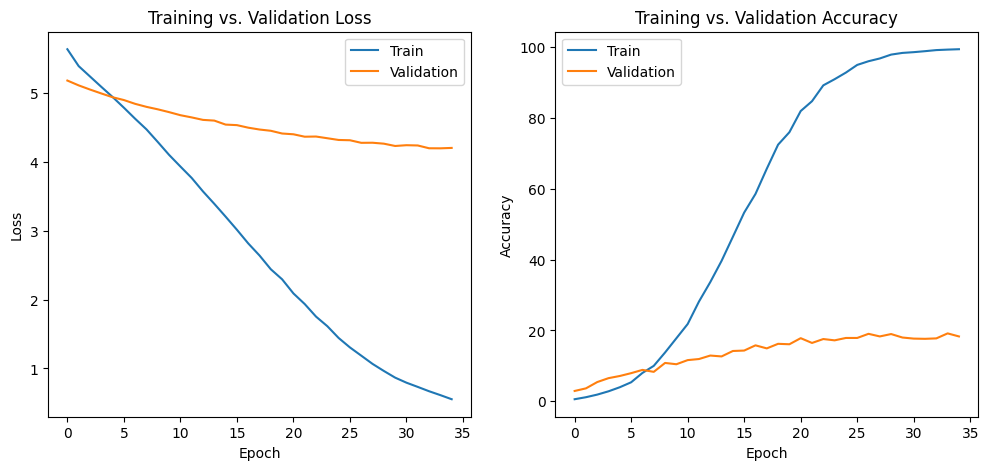

Accuracy: 0.2005
F1 Score: 0.1928
Precision: 0.2449
Recall: 0.2005
time: 15min 4s (started: 2025-03-03 12:43:57 +00:00)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
%%script echo skipping

train_loss, val_loss, train_acc, val_acc = training_loop(
    exp_3_2_model, optimizer, criterion, epochs, train_loader, val_loader)

visualize_results(train_loss, val_loss, train_acc, val_acc)
generate_classification_report(exp_3_2_model, test_loader, device)

## Exp 3 - More, Bigger Convoloutions

We Searched for CNN implementations that worked well for CIFAR task and we found [Tungs Model](https://github.com/LeoTungAnh/CNN-CIFAR-100/blob/main/README.md). Running his Concolountion was too large for us so we had to reduce it.  he got 66% score in CIFAR
100 (recognizing 100 classes) with 4 convoloution blocks - one 256 filters and
the other 3 512 filters with a 3X3 kernel. We tried running it but only 1 epoch
took too long for us. Instead we did the same 4 convoloution blocks but with
smaller convoloutions.

In [ ]:
class Exp_3_3_model(nn.Module):
    def __init__(self):
        super(Exp_3_3_model, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)

        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding='same')
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 14 * 14, 2048)
        self.bn9 = nn.BatchNorm1d(2048, momentum=0.95, eps=0.005)
        self.dropout5 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(2048, 196)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = torch.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = torch.relu(x)
        x = self.conv8(x)
        x = self.bn8(x)
        x = torch.relu(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.bn9(x)
        x = torch.relu(x)
        x = self.dropout5(x)
        x = self.fc2(x)
        x = torch.softmax(x, dim=1)
        return x

# Create an instance of the model
exp_3_3_model = Exp_3_3_model()
exp_3_3_model.to(device)

Exp_3_3_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=

time: 886 ms (started: 2025-02-18 11:39:25 +00:00)


In [ ]:
epochs=50
lr = 0.00005
weight_decay = 0.005

optimizer = optim.Adam(exp_3_3_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

time: 8.05 ms (started: 2025-02-18 11:39:32 +00:00)


Epoch [1/50], Loss: 5.2734, Validation Loss: 5.2683, Validation Accuracy: 1.84%
Epoch [2/50], Loss: 5.2576, Validation Loss: 5.2669, Validation Accuracy: 1.90%
Epoch [3/50], Loss: 5.2389, Validation Loss: 5.2530, Validation Accuracy: 3.25%
Epoch [4/50], Loss: 5.2130, Validation Loss: 5.2528, Validation Accuracy: 3.25%
Epoch [5/50], Loss: 5.1773, Validation Loss: 5.2391, Validation Accuracy: 4.91%
Epoch [6/50], Loss: 5.1444, Validation Loss: 5.2286, Validation Accuracy: 6.14%
Epoch [7/50], Loss: 5.1144, Validation Loss: 5.2323, Validation Accuracy: 5.89%
Epoch [8/50], Loss: 5.0845, Validation Loss: 5.2232, Validation Accuracy: 6.57%
Epoch [9/50], Loss: 5.0552, Validation Loss: 5.2178, Validation Accuracy: 7.55%
Epoch [10/50], Loss: 5.0230, Validation Loss: 5.2124, Validation Accuracy: 7.86%
Epoch [11/50], Loss: 4.9889, Validation Loss: 5.1981, Validation Accuracy: 9.52%
Epoch [12/50], Loss: 4.9501, Validation Loss: 5.1926, Validation Accuracy: 10.07%
Epoch [13/50], Loss: 4.9163, Validat

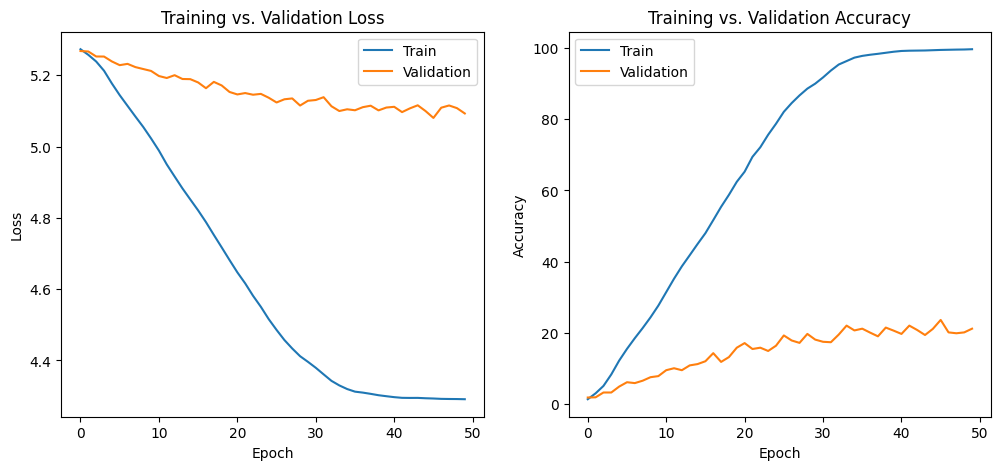

Accuracy: 0.2046
F1 Score: 0.2069
Precision: 0.3602
Recall: 0.2046


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
%%script echo skipping

train_loss, val_loss, train_acc, val_acc = training_loop(
    exp_3_3_model, optimizer, criterion, epochs, train_loader, val_loader)

visualize_results(train_loss, val_loss, train_acc, val_acc)
generate_classification_report(exp_3_3_model, test_loader, device)

## Save Model

In [ ]:
model_filename = "exp-3-3-best-weights"
#save_best_model(exp_3_3_model)

time: 455 µs (started: 2025-02-18 09:08:30 +00:00)


## Test Model

In [ ]:
class Exp_3_3_model(nn.Module):
    def __init__(self):
        super(Exp_3_3_model, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)

        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding='same')
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 14 * 14, 2048)
        self.bn9 = nn.BatchNorm1d(2048, momentum=0.95, eps=0.005)
        self.dropout5 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(2048, 196)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = torch.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = torch.relu(x)
        x = self.conv8(x)
        x = self.bn8(x)
        x = torch.relu(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.bn9(x)
        x = torch.relu(x)
        x = self.dropout5(x)
        x = self.fc2(x)
        x = torch.softmax(x, dim=1)
        return x

# Create an instance of the model
exp_3_3_model = Exp_3_3_model()
exp_3_3_model.to(device)

Exp_3_3_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=

time: 963 ms (started: 2025-03-03 13:27:39 +00:00)


In [ ]:
!gdown 16HkFe1dS66JmtgV-y0C5UtWa969S4veN # exp-3-3-best-weights
model_filename = "exp-3-3-best-weights"
exp_3_3_model.load_state_dict(torch.load(f'/content/{model_filename}', map_location=device))

Downloading...
From (original): https://drive.google.com/uc?id=16HkFe1dS66JmtgV-y0C5UtWa969S4veN
From (redirected): https://drive.google.com/uc?id=16HkFe1dS66JmtgV-y0C5UtWa969S4veN&confirm=t&uuid=7de32c94-d02d-43aa-ba7b-805a1b2ea19f
To: /content/exp-3-3-best-weights
100% 417M/417M [00:02<00:00, 144MB/s]


<ipython-input-20-0d9afc829d9a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp_3_3_model.load_state_dict(torch.load(f'/content/{model_filename}', map_location=device))

<All keys matched successfully>

time: 7.85 s (started: 2025-03-03 13:27:56 +00:00)


Saving 00001.jpg to 00001 (1).jpg
Saving 00002.jpg to 00002 (1).jpg
Saving 00003.jpg to 00003 (1).jpg


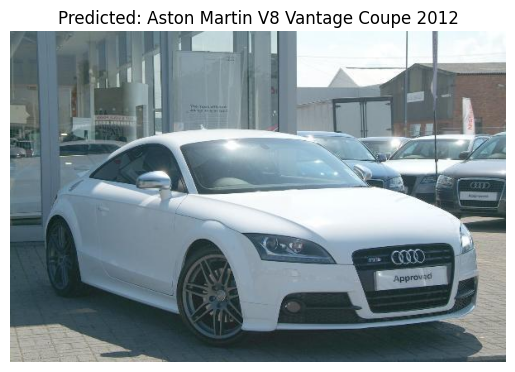

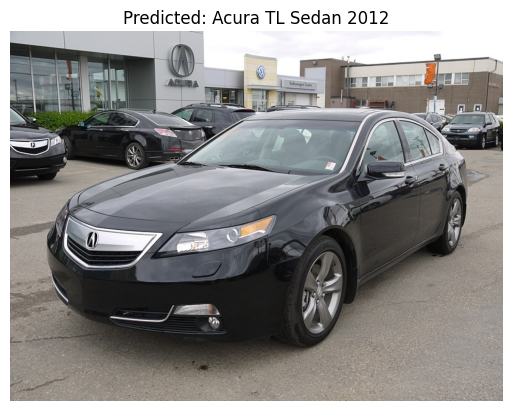

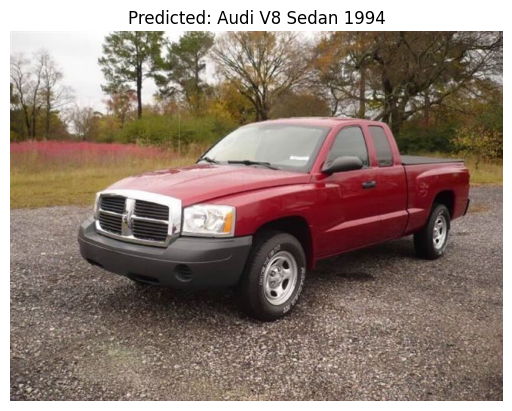

time: 9.48 s (started: 2025-03-03 13:28:05 +00:00)


In [ ]:
#%%script echo skipping
test_model_upload_images(exp_3_3_model, normalize_stanford)

# CNN - YOAV

## Pre-Processing

here we would create a robust dataset to train our cnn on.
- convert images to grayscale
- resize images to be smaller
- normalize images
- convert data from the train set to have more train
- add augmentation images to the train set

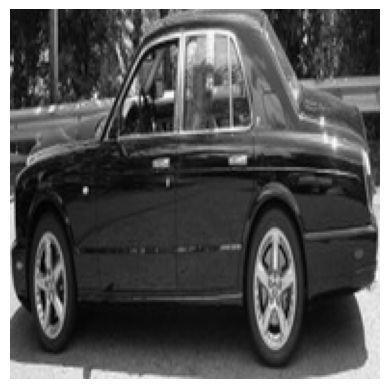

In [41]:
all_stanford_cars = train_cars + test_cars

train_car = train_cars[140].get_image()
train_car_tensor_image = create_image_grayscale_tensor(train_car, size=(192,192))
display_tensor(train_car_tensor_image, grayscale=True)

### create grayscale tensors

### Save grayscale tensors 

In [ ]:
%%script echo skipping
from cars_dataset import redistribute_test_data

size = (160,160)
train_image_grayscale_tensors = resize_images(train_cars,grayscale=True, size=size)
test_image_grayscale_tensors = resize_images(test_cars, grayscale=True, size=size)

if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

Resizing Images: 100%|██████████| 8041/8041 [00:44<00:00, 179.06it/s]


In [45]:
%%script echo skipping
%mkdir ./grayscale-tensors

skipping


In [ ]:
%%script echo skipping
torch.save(train_image_grayscale_tensors, "./grayscale-tensors/train.pt")
torch.save(test_image_grayscale_tensors, "./grayscale-tensors/test.pt")

### load tensors

In [100]:
#%%script echo skipping

def load_image_tensors() -> Tuple[torch.Tensor, torch.Tensor]:
  train_image_grayscale_tensors = torch.load("./grayscale-tensors/train.pt", map_location="cpu") # data would load to the gpu in training.
  test_image_grayscale_tensors = torch.load("./grayscale-tensors/test.pt", map_location="cpu")

  return train_image_grayscale_tensors, test_image_grayscale_tensors

train_image_grayscale_tensors, test_image_grayscale_tensors = load_image_tensors()

print(f"train tensors grayscale shape: {train_image_grayscale_tensors.shape}")
print(f"test tensors grayscale shape: {test_image_grayscale_tensors.shape}")


train tensors grayscale shape: torch.Size([8144, 1, 160, 160])
test tensors grayscale shape: torch.Size([8041, 1, 160, 160])


### create dataloaders 

In [ ]:
import importlib
import cars_dataset
importlib.reload(cars_dataset)


torch.Size([8144, 1, 160, 160])
torch.Size([8041, 1, 160, 160])
8144
8144


In [ ]:
from cars_dataset import transfer_test_to_train


cnn_train_tensors, cnn_test_tensors, new_train_cars, new_test_cars = transfer_test_to_train(
    train_image_grayscale_tensors, test_image_grayscale_tensors, train_cars, test_cars
)

cnn_train_labels = np.array([car.class_label for car in new_train_cars])
cnn_test_labels = np.array([car.class_label for car in new_test_cars])


New train tensor shape: torch.Size([11360, 1, 160, 160])
New test tensor shape: torch.Size([4825, 1, 160, 160])
New train cars length: 11360
New test cars length: 4825


In [111]:
from cars_dataset import CarsDataset, get_train_val_dataset  

batch_size = 64
num_workers = 4

train_dataset, val_dataset = get_train_val_dataset(list(cnn_train_tensors), cnn_train_labels)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True )
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True)

test_dataset = CarsDataset(list(cnn_test_tensors), cnn_test_labels)
test_loader = DataLoader(test_dataset, batch_size,shuffle=False, pin_memory=True)

## Exp 1 - Naive Approach

In [112]:
class Grayscale_CNN_exp_1_GAP(nn.Module):
    def __init__(self, num_classes=196):
        super(Grayscale_CNN_exp_1_GAP, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling Layer
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Output size of (1, 1)

        # Final classification layer
        self.fc3 = nn.Linear(64, num_classes)  # Input is now just the number of channels

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Apply Global Average Pooling
        x = self.gap(x)
        x = torch.flatten(x, 1)  # Flatten to [batch_size, 64]

        # Classification
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
# Create an instance of the model
grayscale_cnn_exp1_model = Grayscale_CNN_exp_1_GAP()
grayscale_cnn_exp1_model.to(device)

Grayscale_CNN_exp_1_GAP(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc3): Linear(in_features=64, out_features=196, bias=True)
)

Epoch [1/30], Loss: 5.2982, Validation Loss: 5.3344, Validation Accuracy: 0.53%


Epoch [2/30], Loss: 5.1845, Validation Loss: 5.3151, Validation Accuracy: 0.88%


Epoch [3/30], Loss: 5.1226, Validation Loss: 5.1748, Validation Accuracy: 1.17%


Epoch [4/30], Loss: 5.0017, Validation Loss: 5.1398, Validation Accuracy: 2.11%


Epoch [5/30], Loss: 4.8233, Validation Loss: 5.0322, Validation Accuracy: 2.52%


Epoch [6/30], Loss: 4.6348, Validation Loss: 5.6599, Validation Accuracy: 2.58%


Epoch [7/30], Loss: 4.4206, Validation Loss: 4.5615, Validation Accuracy: 5.63%


Epoch [8/30], Loss: 4.2148, Validation Loss: 5.1448, Validation Accuracy: 4.58%


Epoch [9/30], Loss: 4.0097, Validation Loss: 4.6204, Validation Accuracy: 7.51%


Epoch [10/30], Loss: 3.8401, Validation Loss: 4.5231, Validation Accuracy: 8.98%


Epoch [11/30], Loss: 3.6748, Validation Loss: 6.5411, Validation Accuracy: 3.52%


Epoch [12/30], Loss: 3.5312, Validation Loss: 4.2057, Validation Accuracy: 10.97%


Epoch [13/30], Loss: 3.4052, Validation Loss: 4.1731, Validation Accuracy: 12.21%


Epoch [14/30], Loss: 3.2541, Validation Loss: 4.1782, Validation Accuracy: 12.56%


Epoch [15/30], Loss: 3.1543, Validation Loss: 3.9969, Validation Accuracy: 15.43%


Epoch [16/30], Loss: 3.0527, Validation Loss: 4.6520, Validation Accuracy: 10.97%


Epoch [17/30], Loss: 2.9449, Validation Loss: 4.1847, Validation Accuracy: 14.85%


Epoch [18/30], Loss: 2.8046, Validation Loss: 4.3039, Validation Accuracy: 13.09%


Epoch [19/30], Loss: 2.7325, Validation Loss: 4.1608, Validation Accuracy: 15.96%


Epoch [20/30], Loss: 2.6632, Validation Loss: 4.3546, Validation Accuracy: 13.79%


Epoch [21/30], Loss: 2.5910, Validation Loss: 4.1782, Validation Accuracy: 15.96%


Epoch [22/30], Loss: 2.4977, Validation Loss: 4.0077, Validation Accuracy: 17.55%


Epoch [23/30], Loss: 2.4366, Validation Loss: 3.7385, Validation Accuracy: 21.07%


Epoch [24/30], Loss: 2.3462, Validation Loss: 4.1261, Validation Accuracy: 18.60%


Epoch [25/30], Loss: 2.3090, Validation Loss: 3.4182, Validation Accuracy: 23.88%


Epoch [26/30], Loss: 2.2238, Validation Loss: 3.4795, Validation Accuracy: 24.30%


Epoch [27/30], Loss: 2.1639, Validation Loss: 3.5965, Validation Accuracy: 22.71%


Epoch [28/30], Loss: 2.1141, Validation Loss: 5.1262, Validation Accuracy: 16.49%


Epoch [29/30], Loss: 2.0683, Validation Loss: 3.6090, Validation Accuracy: 21.65%


Epoch [30/30], Loss: 2.0091, Validation Loss: 3.5326, Validation Accuracy: 26.17%


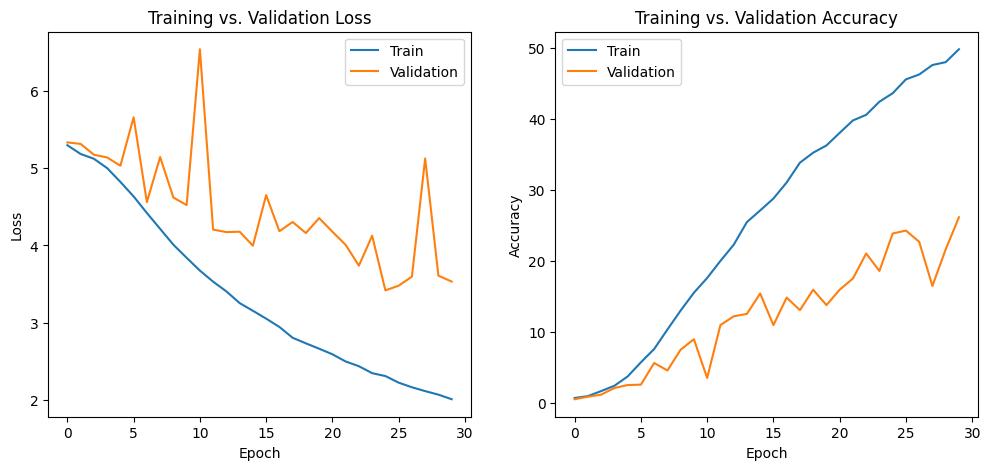

Accuracy: 0.2481
F1 Score: 0.2335
Precision: 0.3919
Recall: 0.2481


/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [113]:
epochs=30
lr=0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(grayscale_cnn_exp1_model.parameters(), lr)

train_loss, val_loss, train_acc, val_acc = training_loop(
    grayscale_cnn_exp1_model, optimizer, criterion, epochs, train_loader, val_loader, none_blocking=True)

visualize_results(train_loss, val_loss, train_acc, val_acc)
generate_classification_report(grayscale_cnn_exp1_model, test_loader, device)
